In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


from SNN.models import SNNLayer
from SNN.utils import temporal_encode

In [2]:
device = torch.device("cuda")

In [41]:
class BinarizeTransform:
    """
    A class to binarize the input MNIST data.
    """
    def __call__(self, img):
        # Values are between 0 and 1 so I have binarized with threshold of 0.5
        return (img>0.5).float()

# Transform to be applied on to the data immediately after loading from location.
transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),
    BinarizeTransform()
])

# Load and transform MNIST data
# mnist_data_train = datasets.MNIST(root="data/MNIST", train=True, download=True, transform=transform)
# mnist_data_test = datasets.MNIST(root="data/MNIST", train=False, download=True, transform=transform)
mnist_data_train = datasets.FashionMNIST(root="data/MNIST", train=True, download=True, transform=transform)
mnist_data_test = datasets.FashionMNIST(root="data/MNIST", train=False, download=True, transform=transform)
# train_size = int(0.9 * len(mnist_data_train))       # Size of the train split
# val_size = len(mnist_data_train) - train_size       # Size of the validation split
train_size, val_size = 50000, 10000

train_data, val_data = random_split(mnist_data_train, [train_size, val_size])


7


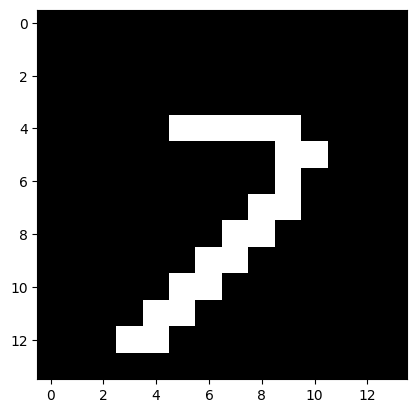

In [44]:
idx = 567
plt.imshow(mnist_data_train[idx][0][0], cmap='grey')
print(mnist_data_train[idx][1])

In [4]:

# Dictionary of all the rows of each mask-set in every file 
json_data = {
    "365nm":{
        "I1":range(0, 5),
        "I2":range(10, 15),
        "I3":range(18, 23),
        "I4":range(25, 30)
    },
    "455nm":{
        "I1":range(0, 5),
        "I2":range(7, 12),
        "I3":range(14, 19),
        "I4":range(21, 26)
    },
    "White":{
        "I1":range(0, 5),
        "I2":range(9, 14),
        "I3":range(16, 21),
        "I4":range(24, 29)
    }
}

In [5]:
combined_tables = []
for filename in ["White", "365nm", "455nm"]:
    path = "data/"+filename+".xlsx" 
    df = pd.read_excel(path, usecols='B:Q') # Read the excel sheet
    tables = [df.iloc[json_data[filename][key]].copy().reset_index(drop=True) for key in list(json_data[filename].keys())]
    combined_table = pd.concat(tables, axis=0)
    combined_tables.append(combined_table)
    del(df, tables, combined_table)

combined_tables[1] = combined_tables[1].reindex(columns=combined_tables[0].columns)

<Axes: >

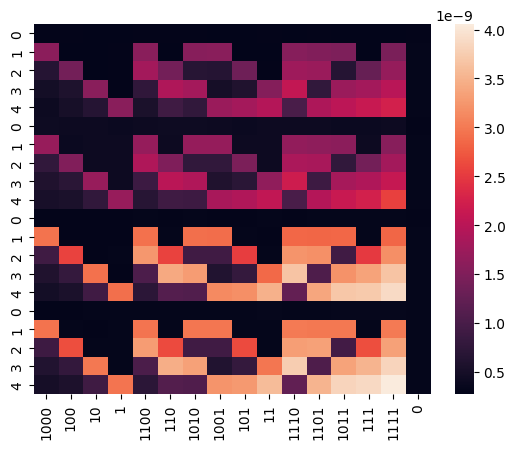

In [12]:
sns.heatmap(combined_tables[2])

In [117]:
NUMBER_OF_MASKS = 4
colour_indices = np.array([0, 1, 2])  # Optical masks: 0, 1, 2
intensity_indices = np.array([0, 1, 2, 3])  # Electrical masks: 0, 1, 2, 3

# Generate a meshgrid of all combinations, so that we don't sample same pair twice
colour_masks, intensity_masks = np.meshgrid(colour_indices, intensity_indices, indexing='ij')
all_pairs = np.column_stack((colour_masks.ravel(), intensity_masks.ravel()))

unique_indices = np.random.choice(all_pairs.shape[0], size=NUMBER_OF_MASKS, replace=False)

selected_pairs = all_pairs[unique_indices]
colour_masks = selected_pairs[:, 0]
intensity_masks = selected_pairs[:, 1]


# Use this to override previous values,  if you want a specific set of masks
# colour_masks = np.array([2, 2, 1, 0])
# intensity_masks = np.array([3, 2, 3, 1])

colour_masks = np.array([2, 2, 1, 0])
intensity_masks = np.array([3, 2, 3, 1])
NUMBER_OF_MASKS = (len(colour_masks) == len(intensity_masks)) * len(colour_masks)

# Device masks
number_of_devices = int( 28 * 28 /4)
device_mask = np.random.randint(0, 5, (NUMBER_OF_MASKS, number_of_devices))



In [118]:
colour_masks, intensity_masks, device_mask.shape, NUMBER_OF_MASKS

(array([2, 2, 1, 0]), array([3, 2, 3, 1]), (4, 196), 4)

In [119]:

class CustomDataset(Dataset):
    def __init__(self, mnist_data, combined_tables, colour_masks, intensity_masks, device_mask):
        self.processed_data = []
        self.labels = []

        for idx in tqdm(range(len(mnist_data))):
            image, label = mnist_data[idx]
            image = image.reshape(number_of_devices, 4)
            image = (
                image[ :, 0] * 1000 + 
                image[ :, 1] * 100 + 
                image[ :, 2] * 10 + 
                image[ :, 3]
            )

            column_indices = combined_tables[0].columns.get_indexer(image.tolist())
            x = []
            for j, (optical_mask, electrical_mask) in enumerate(zip(colour_masks, intensity_masks)):
                required_table = combined_tables[optical_mask]\
                                .iloc[electrical_mask*5:(electrical_mask+1)*5]\
                                .iloc[device_mask[j]]
                # x.append(required_table.values[np.arange(device_mask.shape[-1]), column_indices]*1e9)
                x.append(required_table.values[np.arange(device_mask.shape[-1]), column_indices]*1e8)
            
            x = np.concatenate(x, axis=0)
            
            self.processed_data.append(x)
            self.labels.append(label)
        self.processed_data = torch.tensor(self.processed_data).to(device=device)
        self.labels = torch.tensor(self.labels).to(device=device)

    
    def __len__(self):
        return self.processed_data.shape[0]

    def __getitem__(self, idx):
        return self.processed_data[idx], self.labels[idx]




In [120]:
class ReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 10)
        self.activation = nn.functional.leaky_relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x
    
class SNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SNN, self).__init__()

        # self.snn1 = SNNLayer(input_size=input_size, output_size=128)
        # self.snn2 = SNNLayer(input_size=128, output_size=num_classes)

        self.readout_layer = SNNLayer(input_size=input_size, output_size=num_classes)
        # self.readout_layer = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1, x.size(-1))
        # x = self.snn1(x)
        # x = self.snn2(x)
        x = self.readout_layer(x)
        return x.mean(-1)
    


In [121]:
train_dataset = CustomDataset(train_data, combined_tables, colour_masks, intensity_masks, device_mask)
validation_dataset = CustomDataset(val_data, combined_tables, colour_masks, intensity_masks, device_mask)
test_dataset = CustomDataset(mnist_data_test, combined_tables, colour_masks, intensity_masks, device_mask)

BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



100%|██████████| 10000/10000 [00:09<00:00, 1033.88it/s]


In [122]:
# idx = 19
# imgs = train_dataset[idx][0].reshape(NUMBER_OF_MASKS* 14, 14).cpu()
# print(train_dataset[idx][1])
# plt.imshow(imgs)

In [123]:
test_dataset.processed_data.min(), test_dataset.processed_data.max()

(tensor(0.0207, device='cuda:0', dtype=torch.float64),
 tensor(1.0879, device='cuda:0', dtype=torch.float64))

In [124]:


temporal_encode(test_dataset.processed_data).shape

torch.Size([10000, 784, 20])

Text(0.5, 1.0, 'input pixel intensity distribution')

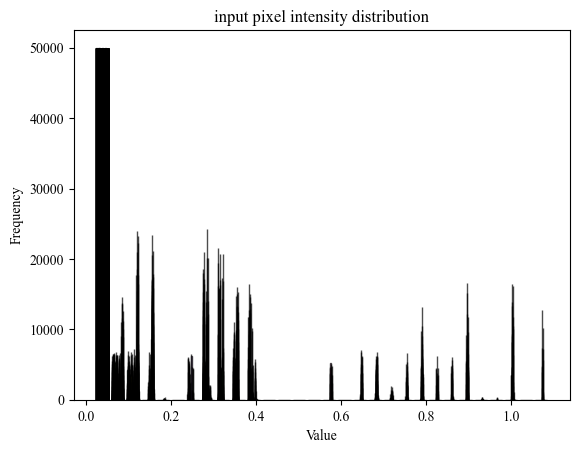

In [125]:


plt.hist(train_dataset.processed_data.cpu().numpy(), bins=30, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('input pixel intensity distribution')

In [126]:
train_dataset[0][0].device

device(type='cuda', index=0)

In [127]:

EPOCHS = 200
learning_rate = 0.0005
# learning_rate = 1e-3

model = ReadoutLayer(number_of_devices*NUMBER_OF_MASKS).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
precision = Precision(task="multiclass", num_classes=10, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=10, average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=10).to(device)

In [128]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
        val_accuracy.append(accuracy.compute().item())
        val_precision.append(precision.compute().item())
        val_recall.append(recall.compute().item())
        val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [1/200], Loss: 2.0655 Validation - Accuracy: 0.5883 Precision: 0.5253  Recall: 0.5831 F1 Score: 0.5218
Epoch [2/200], Loss: 1.8672 Validation - Accuracy: 0.6475 Precision: 0.5470  Recall: 0.6421 F1 Score: 0.5797
Epoch [3/200], Loss: 1.5798 Validation - Accuracy: 0.7380 Precision: 0.7753  Recall: 0.7300 F1 Score: 0.7053
Epoch [4/200], Loss: 1.3470 Validation - Accuracy: 0.7831 Precision: 0.7993  Recall: 0.7772 F1 Score: 0.7726
Epoch [5/200], Loss: 1.2149 Validation - Accuracy: 0.8039 Precision: 0.8114  Recall: 0.7996 F1 Score: 0.7995
Epoch [6/200], Loss: 1.0715 Validation - Accuracy: 0.8136 Precision: 0.8188  Recall: 0.8099 F1 Score: 0.8104
Epoch [7/200], Loss: 1.0388 Validation - Accuracy: 0.8208 Precision: 0.8248  Recall: 0.8175 F1 Score: 0.8183
Epoch [8/200], Loss: 0.8921 Validation - Accuracy: 0.8267 Precision: 0.8295  Recall: 0.8236 F1 Score: 0.8242
Epoch [9/200], Loss: 0.8503 Validation - Accuracy: 0.8326 Precision: 0.8346  Recall: 0.8299 F1 Score: 0.8305
Epoch [10/200], Los

In [129]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1:.4f}')

        

Test Accuracy: 91.37%
Test Precision: 91.2557%
Test Recall: 91.2367%
Test F1 Score: 0.9123


C:\Users\adith\AppData\Local\Temp\ipykernel_17044\3800262208.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


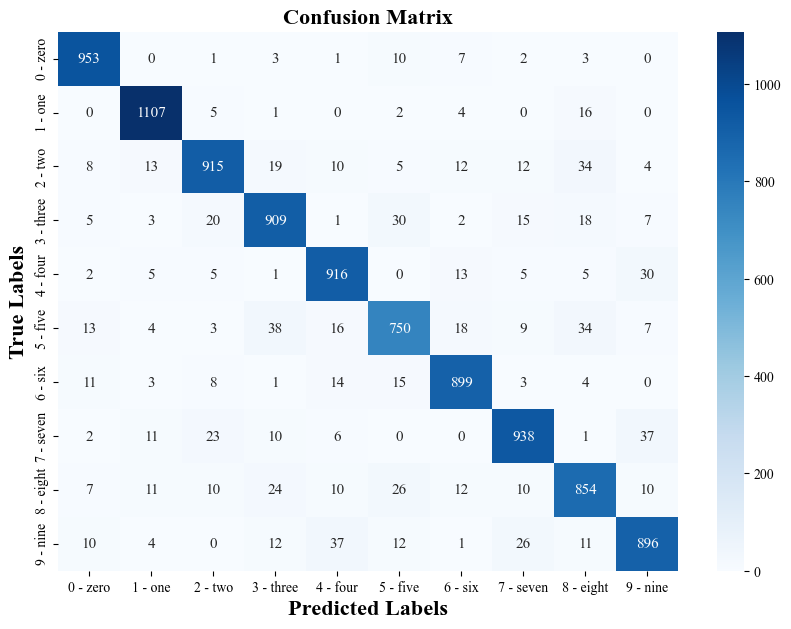

In [130]:

plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix.cpu(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=mnist_data_train.classes, 
            yticklabels=mnist_data_train.classes,
            annot_kws={"size": 11, "family": "Times New Roman"})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.ylabel('True Labels', fontsize=16, fontweight='bold')
plt.show()

In [131]:
x = np.argmax(val_fscore)
print(val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

0.912339985370636 0.9113460183143616 0.9111510515213013 0.9111824631690979


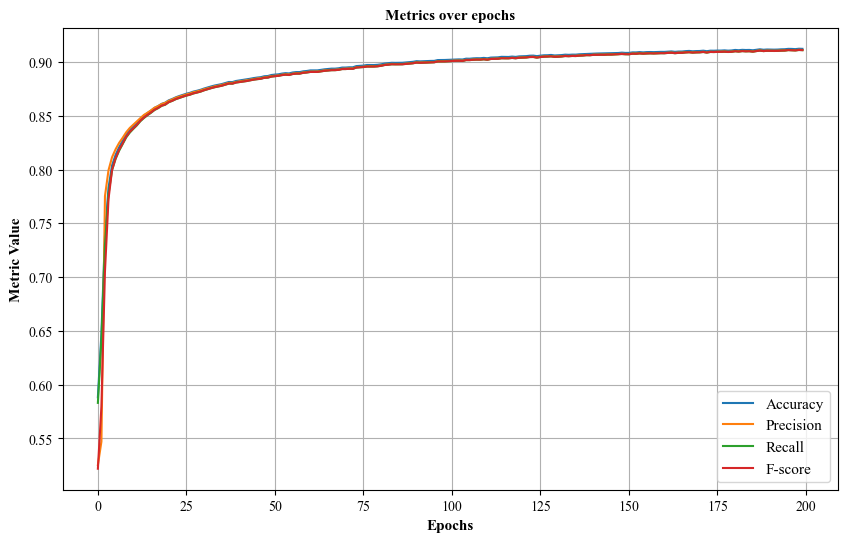

In [132]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], val_accuracy, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], val_precision, label='Precision')
plt.plot([i for i in range(len(val_recall))], val_recall, label='Recall')
plt.plot([i for i in range(len(val_fscore))], val_fscore, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()

In [133]:
# df = pd.DataFrame({
#     "Accuracy": val_accuracy,
#     "Precision": val_precision,
#     "Recall": val_recall,
#     "F-score":val_fscore
# })

# df.to_excel("data/images/fashion_mnist/4/metrics.xlsx")

In [134]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
metrics_data = {
    "Mask" : ''.join(list(map(str, colour_masks))) + '_' + ''.join( list(map(str, intensity_masks)) ),
    "Trainable parameters" : count_parameters(model),
    "Accuracy" : [test_accuracy.item()],
    "Precision": [test_precision.item()],
    "Recall": [test_recall.item()],
    "F-score": [test_f1.item()]
}
print(metrics_data)

{'Mask': '2210_3231', 'Trainable parameters': 7850, 'Accuracy': [0.9136999845504761], 'Precision': [0.9125568270683289], 'Recall': [0.9123673439025879], 'F-score': [0.9123045206069946]}


In [135]:

# df = pd.DataFrame(metrics_data)

# file_path = 'data/metrics_v3.xlsx'

# if os.path.exists(file_path):
#     with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
#         df.to_excel(writer, sheet_name='Sheet1', index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)
# else:
#     with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
#         df.to_excel(writer, sheet_name='Sheet1', index=False)

# print("Data appended to Excel file successfully!")

In [136]:
# save_path = "data/mnist_results_debug/" + metrics_data['Mask'] + '.npz'
# np.savez(save_path,
#             predictions = all_preds,
#             labels = all_labels,
#             validation_accuracy = val_accuracy,
#             validation_precision = val_precision,
#             validation_recall = val_recall,
#             validation_fscore = val_fscore
            
#     )

In [137]:

# plt.figure(figsize=(10, 6))
# plt.plot(val_accuracy, label='Accuracy')
# plt.plot(val_precision, label='Precision')
# plt.plot(val_recall, label='Recall')
# plt.plot(val_fscore, label='F1 Score')

# plt.title('Metrics Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Score')
# # plt.ylim(0, 1) 
# plt.grid(True)

# plt.legend()

In [138]:
data_frames = {ds:[] for ds in ['1', '2', '3', '4']}
for dataset in data_frames.keys():
    df = pd.read_excel(f"data/images/fashion_mnist/{dataset}/metrics.xlsx")
    data_frames[dataset] = df[:500]

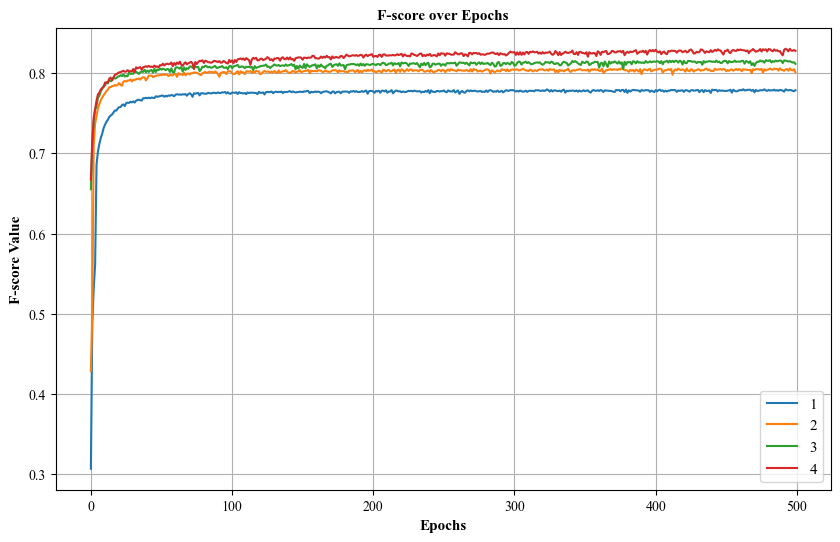

In [139]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"
metric = 'F-score'

for dataset in data_frames.keys():
    values = data_frames[dataset][metric]
    plt.plot([i for i in range(len(values))], values, label=dataset)



# Add title, labels, and legend
plt.title(f"{metric.capitalize()} over Epochs", {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel(f'{metric.capitalize()} Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()